# How accurately can two classification models predict the VADER sentiment of movie reviews?

<b>Objective of the project</b>:

This project aims to evaluate the accuracy of two classification models, Logistic Regression and Naive Bayes, in predicting the VADER sentiment—positive or negative—of movie reviews. The objectives are twofold: first, to compare and contrast the performance of these models, identifying similarities and differences in their scoring; second, to solidify the knowledge gained in class through a comprehensive and practical application of sentiment analysis techniques.

<b>Data</b>

I have scraped the public API of The Movie Data Base (https://www.themoviedb.org/), from which I have pulled out over 2700 reviews from 1030 different movies.

<b>Steps</b>

The steps I have taken to arrive at my final results are the following:

_Step 1_. I have scraped 1000 reviews from a public API of the Movie Data Base;

_Step 2_. I have performed data normalization to the reviews, through tokenization, stop word removal and lemmatization. 

_Step 3_. I have computed the VADER sentiment scores for each review and assigned a value of 1 to the positive reviews and 0 to the negative reviews, based on the compound. I assume that these scores are just "given" for each single review. These are the scores I will predict.

_Step 4_. I have applied the Term Frequency - Inverse Document Frequency Vectorization to extract features out of the reviews, based on the frequency each word appears and their relative importance across the corpus of reviews. This produces a sparse matrix.

_Step 5_. I have fitted a Logistic Regression and a Naive Bayes model using the binary sentiment as response y and the sparse matrix as features X to the models. Given the class imbalance that I get from the data, whereby the majority of reviews are marked as "positive", I undersample the majority class and run the two models again.

_Step 6_. I have evaluated, and compared, the soundness of each model against each other, before and after the undersampling of the majority class and with respect to the the baseline model by looking at different metrics (accuracy, precision, recall and false positive rate).


<b>Results</b>

When I first fit the two models, I get an accuracy that is comparable to that of the baseline model, but I obtain a very low recall for the minority class, whereby only a small portion of the negative reviews were correctly identified by the two models. Also, given the strong class imbalance in favour of positive reviews, the baseline model has an accuracy similar to the one either models leads to. This is not good enough. However, when undersampling the majority class to make sure that there are as many negative reviews as there are positive, which is a rather far-fetched assumption, both models improve drastically in overall accuracy, precision and recall and perform better than the baseline model's accuracy (now 50%).

<b>Limitations</b>

There are several limitations to this project:
- <b>Strong Assumption about VADER sentiment</b>. The model assumes that the VADER sentiment scores accurately represent the true sentiment of the reviewer. However, this might not always be the case, as VADER is known to exhibit a bias toward positive scoring and may not fully capture nuances such as sarcasm, context, or mixed sentiments often present in movie reviews. To address this limitation, future work could incorporate additional features, such as the star ratings provided by reviewers, which could be translated into numerical values to offer a more grounded and diverse perspective on sentiment classification.
- <b>Class Imbalance Handling Through Undersampling</b>. The decision to address class imbalance by undersampling the majority class introduces an artificial balance in the data that may not reflect the real-world distribution of sentiments in movie reviews.
- <b>Limited Dataset Size and Diversity</b>. While 2700 reviews from 1030 movies provide a starting point, the dataset is relatively small for text classification tasks, especially given the complexity of natural language. This limitation may hinder the model's ability to generalize effectively across different types of reviews, genres, or linguistic styles, reducing its robustness in broader applications


In [1]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
api_key = "821c1c9f9dd335f9044e2315fd72f82b"
movie_ids = np.arange(1,3000)
all_reviews={}

for movie_id in movie_ids:
    try:
        url = f"https://api.themoviedb.org/3/movie/{movie_id}/reviews"
        response = requests.get(url, params={"api_key": api_key})
    
        if response.status_code==200:
            reviews = response.json()
            all_reviews[movie_id]=reviews

    except Exception as e:
        print(f"Error fetching movie_id {movie_id}: {e}")


In [3]:
review_data = []

for movie_id, review_response in all_reviews.items():
    if 'results' in review_response:
        reviews = review_response['results']
        for review in reviews:
            review['movie_id'] = movie_id  
            review_data.append(review)  

df_reviews = pd.DataFrame(review_data)

df_reviews = df_reviews[['movie_id', 'author', 'content']]
df_reviews

,movie_id,author,content
0,3,CRCulver,"Released in 1986, Aki Kaurismaki's <i>Varjoja ..."
1,11,Cat Ellington,"(As I'm writing this review, Darth Vader's the..."
2,11,John Chard,A long time ago in a childhood not too far awa...
3,11,gastyny,Star Wars (1977) is a true masterpiece of cine...
4,11,r96sk,A quality start to the franchise.\r\n\r\nI say...
...,...,...,...
2759,2982,John Chard,Irwin Allen asks us politely to get lost in hi...
2760,2988,Wuchak,"**_Love American Style, the college years, alb..."
2761,2989,tmdb15214618,This is not a real movie. Possibly the most re...
2762,2990,John Chard,Pacific Heights – Low Human.\r\n\r\nPacific He...


In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  2764 non-null   int64 
 1   author    2764 non-null   object
 2   content   2764 non-null   object
dtypes: int64(1), object(2)
memory usage: 64.9+ KB


In [5]:
df_reviews["movie_id"].nunique()

1030

## Text Normalization

In [6]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
lemmatizer = WordNetLemmatizer()
regex_tokenizer = RegexpTokenizer("\w+")

### Tokenization

In [7]:
df_reviews["review_lower_text"] = df_reviews["content"].str.lower().apply(word_tokenize)
df_reviews["review_lower_text"] = df_reviews["review_lower_text"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else x)

In [8]:
df_reviews["tokenized_text"] = df_reviews["review_lower_text"].apply(lambda x: regex_tokenizer.tokenize(x) if isinstance(x, str) else [])

### Stop Word Removal 

In [9]:
stop_words = stopwords.words("english")

df_reviews["stop_words_removed_text"] = df_reviews["tokenized_text"].apply(
    lambda tokens: [word for word in tokens if word not in stop_words] if isinstance(tokens, list) else tokens)

### Lemmatization
For this project, lemmatization is used over stemming, as it is generally more accurate for sentiment analysis

In [10]:
wn=WordNetLemmatizer()

def custom_lemmatize(df):
    mapper = { 
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    
    df["lemmatized_text"] = df["stop_words_removed_text"].apply(
        lambda tokens: [
            lemmatizer.lemmatize(word, mapper.get(tag[0], wordnet.NOUN))
            for word, tag in nltk.pos_tag(tokens)
        ] if isinstance(tokens, list) else tokens
    )
    return df

In [11]:
df_reviews = custom_lemmatize(df_reviews)

In [12]:
df_reviews["text"] = df_reviews["lemmatized_text"].apply(lambda x: " ".join(x))

In [13]:
df_reviews.head()

,movie_id,author,content,review_lower_text,tokenized_text,stop_words_removed_text,lemmatized_text,text
0,3,CRCulver,"Released in 1986, Aki Kaurismaki's <i>Varjoja ...","released in 1986 , aki kaurismaki 's < i > var...","[released, in, 1986, aki, kaurismaki, s, i, va...","[released, 1986, aki, kaurismaki, varjoja, par...","[release, 1986, aki, kaurismaki, varjoja, para...",release 1986 aki kaurismaki varjoja paratiisis...
1,11,Cat Ellington,"(As I'm writing this review, Darth Vader's the...","( as i 'm writing this review , darth vader 's...","[as, i, m, writing, this, review, darth, vader...","[writing, review, darth, vader, theme, music, ...","[write, review, darth, vader, theme, music, be...",write review darth vader theme music begin bui...
2,11,John Chard,A long time ago in a childhood not too far awa...,a long time ago in a childhood not too far awa...,"[a, long, time, ago, in, a, childhood, not, to...","[long, time, ago, childhood, far, away, prince...","[long, time, ago, childhood, far, away, prince...",long time ago childhood far away princess leia...
3,11,gastyny,Star Wars (1977) is a true masterpiece of cine...,star wars ( 1977 ) is a true masterpiece of ci...,"[star, wars, 1977, is, a, true, masterpiece, o...","[star, wars, 1977, true, masterpiece, cinema, ...","[star, war, 1977, true, masterpiece, cinema, d...",star war 1977 true masterpiece cinema definite...
4,11,r96sk,A quality start to the franchise.\r\n\r\nI say...,a quality start to the franchise . i say start...,"[a, quality, start, to, the, franchise, i, say...","[quality, start, franchise, say, start, guess,...","[quality, start, franchise, say, start, guess,...",quality start franchise say start guess depend...


## VADER Sentiment Scores

In [14]:
sa=SentimentIntensityAnalyzer()

In [15]:
df_reviews["vader_sentiment"] = df_reviews["text"].apply(lambda x: sa.polarity_scores(x)["compound"])

In [16]:
df_reviews["sentiment"] = np.where(df_reviews["vader_sentiment"]>=0, 1, 0)

In [17]:
df_reviews.drop(["content","review_lower_text","tokenized_text", "stop_words_removed_text", "lemmatized_text"], axis=1, inplace=True)

In [18]:
df_reviews.head()

,movie_id,author,text,vader_sentiment,sentiment
0,3,CRCulver,release 1986 aki kaurismaki varjoja paratiisis...,0.9778,1
1,11,Cat Ellington,write review darth vader theme music begin bui...,0.9844,1
2,11,John Chard,long time ago childhood far away princess leia...,0.9963,1
3,11,gastyny,star war 1977 true masterpiece cinema definite...,0.9815,1
4,11,r96sk,quality start franchise say start guess depend...,0.9864,1


### Basic Statistics and Data Visualization

In [19]:
df_reviews["vader_sentiment"]=df_reviews["vader_sentiment"].astype(float)
df_reviews["vader_sentiment"].mean()

0.6002595875542692

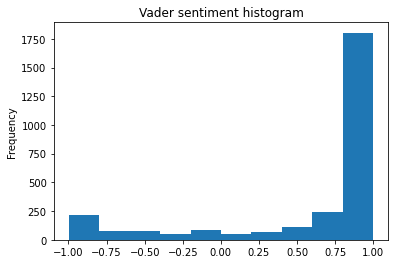

In [20]:
df_reviews.vader_sentiment.plot(kind="hist"); 
plt.title("Vader sentiment histogram");

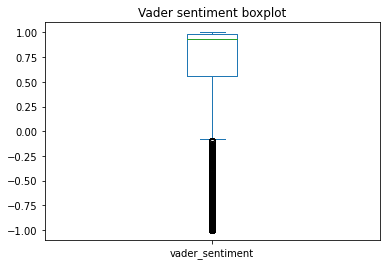

In [21]:
df_reviews.vader_sentiment.plot(kind="box"); 
plt.title("Vader sentiment boxplot");

In [22]:
df_reviews["sentiment"].describe()

count    2764.000000
mean        0.836469
std         0.369916
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: sentiment, dtype: float64

In [23]:
df_reviews["sentiment"].value_counts()

sentiment
1    2312
0     452
Name: count, dtype: int64

In [24]:
share_0=df_reviews["sentiment"].value_counts()[0]/len(df_reviews)
share_0

0.16353111432706222

By plotting an histogram of the vader sentiment scores, we see that most reviews have positive scores. Only around 16% of all reviews are marked negatively. By plotting a box plot, we also see that most negative scores are marked as outliers.
This can a be a limitation for our model, as we might have selected a rather peculiar sample
our of thousands of thousands movie reviews. This might have negative implications for our model's ability
to generalize to other samples, potentially leading to data overfitting.

##  The Term Frequency - Inverse Document Frequency Vectorization for Feature Extraction
- I use the TF - IDF vectorization method instead of the Count vectorization one given that the former focuses on tokens that are more informative. As a rule of thumb, I assume this to be important in the context of modeling movie reviews. 
- I set ngram_range=(1,2), thus allowing for both unigrams and bigrams, as I want to lump together remarks such as "not enjoyable".
- When I split the data, I add _stratify=y_ to account for the class imbalance, ie. the fact that only 16% of the reviews are negative

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [26]:
X = df_reviews["text"]
y = df_reviews["sentiment"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [28]:
tvec = TfidfVectorizer(ngram_range=(1,2))

In [29]:
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [30]:
X_train_tvec.shape

(2073, 225482)

In [31]:
X_train_df = pd.DataFrame(X_train_tvec.toarray(),
                         columns=tvec.get_feature_names_out())

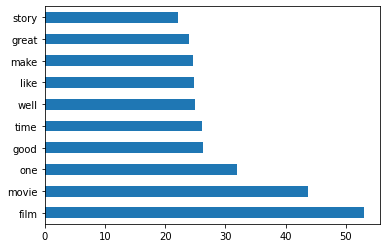

In [32]:
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind="barh");
#the most popular words within the reviews data frame are, unsurpisingly, film and movie. 
#At the same time, "good", "great", "well" are also among the most popular tokens, corroborating the high overall positive scores

## Modeling using the VADER sentiment scores and TF - IDF

In the modeling part, I compare the output of three different classification models learned throughout the course: Logistic Regression, K-Nearest Neighbors and Naive Bayses, to understand how differently they perform on the reviews I have selected and identify the one that is most suited to the problem at hand. 

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn import metrics

### 1. Baseline model
Baseline accuracy is achieved by always predicting the most frequent class. In this particular scenario, as we have a large share of positive reviews, th accuracy of always predicting the most frequent class is relatively high.

In [34]:
accurancy_baseline_model = y_train.value_counts(normalize=True)[1]
print(f' The accuracy of the baseline model is {accurancy_baseline_model:.4f}')

 The accuracy of the baseline model is 0.8365


### 2. Logistic Regression

In [35]:
logreg = LogisticRegression(class_weight="balanced", max_iter=1000)

In [36]:
logreg.fit(X_train_tvec, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [37]:
y_pred_train_logreg = logreg.predict(X_train_tvec)
y_pred_test_logreg = logreg.predict(X_test_tvec)

In [38]:
logreg_pred_proba = logreg.predict_proba(X_test_tvec)[:,1]
print(logreg_pred_proba)

[0.57159933 0.59656461 0.68506778 0.60054073 0.70369974 0.79487477
 0.57680323 0.40637323 0.50139715 0.68900602 0.68881024 0.57373445
 0.56681813 0.60925406 0.72444982 0.57607626 0.71234582 0.69146813
 0.67506352 0.58293    0.63002567 0.68367236 0.73379132 0.64283956
 0.62758125 0.63266096 0.57373445 0.61504969 0.75913634 0.67542925
 0.68858642 0.64860818 0.61811527 0.66387317 0.57028708 0.71093821
 0.61322108 0.66333744 0.58170264 0.75236684 0.62785    0.65380703
 0.69866983 0.8046707  0.73923238 0.6307507  0.77358805 0.61255367
 0.53453869 0.6546926  0.7117738  0.57265179 0.64481973 0.7892158
 0.81437276 0.73891029 0.56583797 0.64326845 0.63448932 0.6017155
 0.67555413 0.68297636 0.52379889 0.71112101 0.43330174 0.6935772
 0.52184152 0.64987837 0.70335202 0.68345878 0.46143164 0.61879764
 0.62285444 0.74304338 0.46483738 0.8039138  0.65009337 0.70595544
 0.75980052 0.68692057 0.61214758 0.6840636  0.64442695 0.63273499
 0.78098622 0.55963712 0.5929161  0.74148588 0.68599998 0.6471183

#### Evaluation of the model

In [39]:
accuracy_train_logreg = np.mean(y_train==y_pred_train_logreg)
accuracy_test_logreg = np.mean(y_test==y_pred_test_logreg)
print(f"The logistic regression training accuracy is {accuracy_train_logreg}")
print(f"The logistic regression testing accuracy is {accuracy_test_logreg}")

The logistic regression training accuracy is 0.9995176073323685
The logistic regression testing accuracy is 0.8726483357452967


I try to correct for class imbalance using _class_weight="balanced"_. This adjusts the weight of each class so that the model pays equal attention to all classes. However, when looking at the training and testing accuracy, there seems to be a large difference between the testing and training accuracy, which is a signal that the model overfits the data.

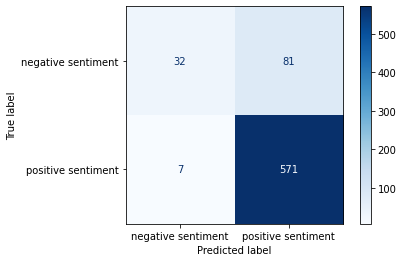

In [40]:
class_names = ["negative sentiment", "positive sentiment"]
ConfusionMatrixDisplay.from_estimator(logreg, X_test_tvec, y_test,
                                 display_labels=class_names, cmap=plt.cm.Blues);

When looking at the confusion matrix, while the logistic regression model is able to correctly predict 573 positive and 32 negative reviews, respectively, it also results in a large number of false positives. 81 negative reviews are actually predicted to be positive.

In [41]:
print(metrics.classification_report(y_test, y_pred_test_logreg))

              precision    recall  f1-score   support

           0       0.82      0.28      0.42       113
           1       0.88      0.99      0.93       578

    accuracy                           0.87       691
   macro avg       0.85      0.64      0.67       691
weighted avg       0.87      0.87      0.85       691



Based on classification report above:
- <b>Precision</b> is rather high for both positive and negative reviews. 88% of the reviews predicted as positive are actually positive. 82% of the reviews predicted as negative are actually negatively.
- <b>Recall</b> is rather low for the negative reviews. Only 28% of the actual negative reviews were correctly identified. The model contains a lot of false positives (reviews that were predicted positive but are in fact negative) and not enough false negatives.
- <b>Overall accuracy</b> is 87%. This is slightly higher than our baseline model. However, given that our training data has a higher accuracy than our testing data, we can conclude that the model is overfitting the data.

#### Undersampling the majority class - Logistic Regression
This technique is used to address class imbalances by reducing the number of samples in the majority class (positive reviews) to balance the number of observations in the minority class (negative reviews).

In [42]:
from sklearn.utils import resample

In [43]:
positive_reviews = df_reviews[df_reviews['sentiment'] == 1]
negative_reviews = df_reviews[df_reviews['sentiment'] == 0]

In [44]:
positive_reviews_downsampled = resample(positive_reviews, replace=False, n_samples=len(negative_reviews), random_state=42)

In [45]:
balanced_reviews = pd.concat([positive_reviews_downsampled, negative_reviews])
balanced_reviews = balanced_reviews.sample(frac=1, random_state=42).reset_index(drop=True)

In [46]:
print(balanced_reviews['sentiment'].value_counts())

sentiment
1    452
0    452
Name: count, dtype: int64


In [47]:
#X and y extracted from the balanced review dataframe
X_br = balanced_reviews['text']
y_br = balanced_reviews['sentiment']

In [48]:
print(len(X_br))
print(len(y_br))

904
904


In [49]:
X_train_br, X_test_br, y_train_br, y_test_br = train_test_split(X_br, y_br, test_size=0.3, random_state=42, stratify=y_br)

In [50]:
tvec = TfidfVectorizer(ngram_range=(1,2))
X_train_tvec_br = tvec.fit_transform(X_train_br)
X_test_tvec_br = tvec.transform(X_test_br)

In [51]:
logreg_br = LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000)
logreg_br.fit(X_train_tvec_br, y_train_br)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

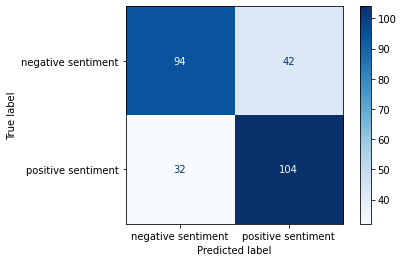

In [52]:
class_names = ["negative sentiment", "positive sentiment"]
ConfusionMatrixDisplay.from_estimator(logreg_br, X_test_tvec_br, y_test_br,
                                 display_labels=class_names, cmap=plt.cm.Blues);

In [63]:
y_pred_test_logreg_br = logreg_br.predict(X_test_tvec_br)
y_pred_train_logreg_br=logreg_br.predict(X_train_tvec_br)

print(classification_report(y_test_br, y_pred_test_logreg_br))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       136
           1       0.71      0.76      0.74       136

    accuracy                           0.73       272
   macro avg       0.73      0.73      0.73       272
weighted avg       0.73      0.73      0.73       272



In [65]:
accurancy_baseline_model_br = y_train_br.value_counts(normalize=True)[1]
print(f' The accuracy of the baseline model is {accurancy_baseline_model_br:.4f}')

 The accuracy of the baseline model is 0.5000


Based on the classification report above, which is the result of udersampling the majority class:
- <b>Precision</b> is slighty lower than in our previous scenario for both positive and negative reviews. 75% of the reviews predicted as negative are actually negative. 71% of the reviews predicted as negative are actually negative.
- <b>Recall</b> is much higher for the negative class. Unlike the initial scenario, where recall was 28%, it is now at 75%, meaning that 75% of the negative reviews are correctly identified. This time, there are many more true negatives compared to false positives.
- <b>Overall accuracy</b> is 78%. This is much higher than the accuracy of our baseline model, which is now only 50%.

### 3. Naive Bayes classifier

In [54]:
nb = MultinomialNB()

In [55]:
#Above, I already imposed tvec.fit_transform(X_train) and tvec_transform(X_test)
nb.fit(X_train_tvec, y_train)

MultinomialNB()

#### Evaluation of the model

In [56]:
print(f' The Naives Bayes training accuracy is {nb.score(X_train_tvec, y_train)}')
print(f' The Naives Bayes testing accuracy is {nb.score(X_test_tvec, y_test)}')

 The Naives Bayes training accuracy is 0.8364688856729378
 The Naives Bayes testing accuracy is 0.8364688856729378


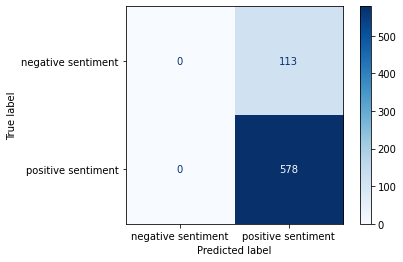

In [57]:
class_names = ["negative sentiment", "positive sentiment"]
ConfusionMatrixDisplay.from_estimator(nb, X_test_tvec, y_test,
                                 display_labels=class_names, cmap=plt.cm.Blues);

In [58]:
y_pred_test_nb = nb.predict(X_test_tvec)
print(metrics.classification_report(y_test, y_pred_test_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.84      1.00      0.91       578

    accuracy                           0.84       691
   macro avg       0.42      0.50      0.46       691
weighted avg       0.70      0.84      0.76       691



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Based on the classification report above:
- <b>precision</b> is 0 for the negative reviews as the model does not predict any negative review. It is 84% for the positive reviews, implying that 84% of the reviews predicted as positive are actually positive.
- <b>precision</b> is 0 for the negative reviews and 1 for the positive reviews, as the model does not find any false negatives.
- <b>overall accuracy </b> is 84%, in line with our baseline model.

#### Undersampling the majority class - Naive Bayes
I fit a NB model using the balanced reviews dataset I obtained by undersampling the majority class. The data had already been split into train and test.

In [59]:
nb_br = MultinomialNB()
nb_br.fit(X_train_tvec_br, y_train_br)

MultinomialNB()

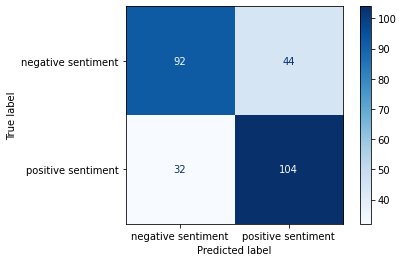

In [60]:
class_names = ["negative sentiment", "positive sentiment"]
ConfusionMatrixDisplay.from_estimator(nb_br, X_test_tvec_br, y_test_br,
                                 display_labels=class_names, cmap=plt.cm.Blues);

In [61]:
y_pred_test_nb_br = nb_br.predict(X_test_tvec_br)

print(classification_report(y_test_br, y_pred_test_nb_br))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71       136
           1       0.70      0.76      0.73       136

    accuracy                           0.72       272
   macro avg       0.72      0.72      0.72       272
weighted avg       0.72      0.72      0.72       272



Based on the classification report above:
- <b>precision</b> has drastically improved for the negative class. Now 74% of the movies the model predicts as being negative are actually negative.
- <b>recall</b> has also improved for the negative class. Now 68% of all movie reviews are predicted to be negative. This hsa improved given that the model contains more true negatives and fewer false positives.
- <b>overall accuracy</b> is also higher with respect to the baseline model's accuracy (50%).

By comparing between the logistic regression and the Naive Bayes after having undersampled the data to account for the class imbalance, the logistic regression seems to perform better on this data. This is because the latter contains slighly more true negatives than the former, contributing to slightly higher precision, recall and overall accuracy.